In [ ]:
from scripts import helpers, mlogo


> Dataset loaded


IndexError: index 1 is out of bounds for axis 0 with size 1

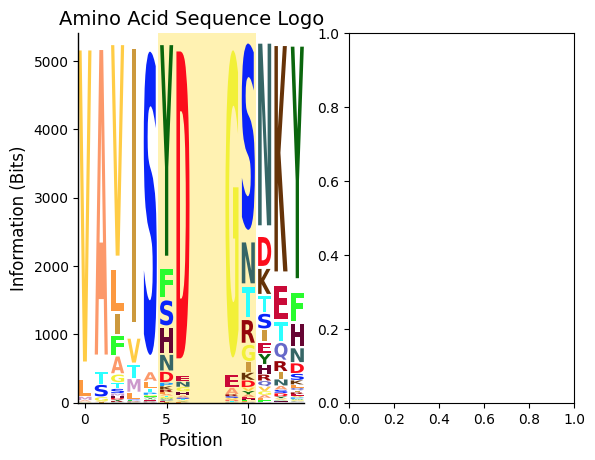

In [38]:
# Modules import
import os 
import pandas as pd
import numpy as np
from scripts import helpers
import pandas as pd
import matplotlib.pyplot as plt
import logomaker

# Class that generate motif-logo and perform data analysis on DNA sequences
class mlogo():
    """
    Class that generate motif-logo and perform data analysis on DNA sequences.
    The data can be grouped by the "group_by" argument (column) and generate 
    seperate plot for each subject 
    """

    def __init__(self,
                 seq_file,
                 group_by:str = None,
                 divide_subject:bool = True,
                 subject_col:str = "subject_id",
                 sequence_col:str = "sequence",
                 germline_col:str = "germline"):
        """
        seq_file : str -> file path / df object of sequencing data.
        group_by : str -> group the dataset by this column. will create number of subplots according
                          to the number of unique values in the grouped by column.
        divide_subject : bool -> Generate different plot for each subject under `subject_id` column.
        subject_col : str -> name of the subject column, defualt is `subject_id`. 
        sequence_col : str -> name of the DNA sequence column, defualt it `sequence`.
        germline_col : str -> name of the germline DNA sequence column, defualt it `germline`.
        """
        arguments_input = [group_by,
                           divide_subject,
                           subject_col,
                           sequence_col,
                           germline_col]
        self.init_dict = {i:j for i,j in zip(["group_by", "divide_subject", "subject_col", "sequence_col", "germline_col"], arguments_input)}
        
        
        # Loading sequences dataset
        try:
            if isinstance(seq_file, str):        
                self.seq_df = pd.read_csv(seq_file, index_col=0)
                print(f"> Dataset loaded (seq_file = '{seq_file}')")

            elif isinstance(seq_file, pd.DataFrame):
                 self.seq_df = seq_file
                 print("> Dataset loaded")

        except:
                print(f"> Invalid input, please make sure seq_file argument entred correctly.\n  (Invalid: seq_file = '{seq_file}')")

        # Translating germline and sequence DNA into amino acid sequence
        self.seq_df["sequence_aa"] = self.seq_df["sequence"].apply(helpers.nt_transalte_104) # Somatic sequence
        self.seq_df["germline_aa"] = self.seq_df["germline"].apply(helpers.nt_transalte_104) # Germline sequence
        

    # Plotting the motif logo according to the amino acids position
    def motif_logo(self,
                    aa_start: int = 1,
                    aa_end: int = -1,
                    yaxis_metric : str ="counts"):
        """
        aa_start : int -> Start of the amino acid motif, relative to the amino acid sequence start.
        aa_end : end -> End of the amino acid motif, relative to the amino acid sequence start.
        yaxis_metric -> Metric to be used in the plot y-axis: must be `counts`, `probability`, `weight`, or `information`.
                            (https://logomaker.readthedocs.io/en/latest/implementation.html#logomaker.alignment_to_matrix)
        """
            
        # Translating the amino acid sequences
        seq_list = self.seq_df["sequence_aa"].apply(lambda X : X[aa_start:aa_end])
            
        # 1st step -> Setting initial shape of 1
        # Final shape of the sub-plot will be placed in this variable
        self.subplot_axidx = [1, 1]

        # 2nd step -> getting the shape of the subplot by the values of grouped by / n-subjects
        # Getting unique group by column values (n-cols)
        group_by_value = self.init_dict["group_by"]
        if isinstance(group_by_value, str): 
             gp_unique = self.seq_df[group_by_value].unique() # Unique values in the group by sequence.
             self.subplot_axidx[0] = len(gp_unique) # Number of unique values, will be number of columns.
             cond_gp = [self.seq_df[group_by_value] == i for i in gp_unique] # Conditions of unique values.
            
        # If not group by any column, number of column = 1.
        else:
             cond_gp = np.full((self.seq_df.shape[0],1), True).flatten()
            
        # Getting subjects values (n-rows)
        subject_bool, subject_col = self.init_dict["divide_subject"], self.init_dict["subject_col"]
        subj_unique = self.seq_df[subject_col].unique()
        if subject_bool:
             subj_len = len(subj_unique) # Number of subjects
             self.subplot_axidx[1] = subj_len # Number of rows in the subplot
             cond_subj = [self.seq_df[subject_col] == i for i in subj_unique]

        # if subject not to be divided, rows in sub-plot will be equal to 1.
        else:
             cond_subj = np.full((self.seq_df.shape[0],1), True).flatten()

        # Condition matrix
        self.cond_matrix = [cond_gp, cond_subj]
        self.cond_index = [[i,j] for i in range(0, len(cond_gp)) for j in range(0,len(cond_subj))]

        # 3rd step -> getting the condition indexes (1d or 2d, depend on shape)
        # Getting the shape of the sub-plots based on the condition shape
        if ([1, 1] == self.subplot_axidx):
            ###-cond_idx = [0,0]
            self.cond_matrix = [np.full((self.seq_df.shape[0],1), True).flatten()]
               
        else:
            try:
                reverse_i = {1:0, 0:1}
                i = self.subplot_axidx.index(1)
                ##-cond_idx = [i for i in range(0, self.subplot_axidx[reverse_i[i]])]
                self.cond_matrix = self.cond_matrix[reverse_i[i]]

            except:
                ##-cond_idx = range(0, len(cond_gp) * len(cond_subj))
                self.cond_matrix = [(i & j) for i in cond_gp for j in cond_subj]

                #-cond_idx = [[i,j] for i in range(0, self.subplot_axidx[1]) for j in range(0, self.subplot_axidx[0])]
                #-cond_idx = [i in range(0, len(cond_idx))]
                #-self.cond_matrix = [(i & j) for i in cond_gp for j in cond_subj]
                    
        # Figure initiation
        fig, axs = plt.subplots(ncols=self.subplot_axidx[0], 
                                    nrows=self.subplot_axidx[1],
                                    squeeze=False)
            
        # If shape sub-plot is (1,1) ->
        ###-if [1, 1] == self.subplot_axidx:
        ###-    axs = [axs]
               
        for i, ic in zip(self.cond_index, self.cond_matrix):
            index_col = i[0]
            index_row = i[1] 

            ax = axs[index_row, index_col]

            ### Temp dataframe itiration -> creation of array of sequences according to the condition
            temp_df = self.seq_df[ic]
            temp_seqs = temp_df["sequence_aa"].apply(lambda X : X[aa_start : aa_end]).values


            ### Logomaker sequence aligment and matrix creation
            # Creation of the sequences the Matrix, to_type='probability' are other options.
            aligment_type = 'probability'
            ww_df = logomaker.alignment_to_matrix(sequences=temp_seqs, 
                                                  to_type='counts', 
                                                  pseudocount=0.0,
                                                  characters_to_ignore=".-")


            if (yaxis_metric != "counts") & (yaxis_metric in ["probability", "weight", "information"]):
                info_df = logomaker.transform_matrix(ww_df, 
                                                     from_type='counts', 
                                                     to_type=yaxis_metric, 
                                                     pseudocount=0.001)


            ### Logomaker sub-plot creation
            logo = logomaker.Logo(ww_df,
                                  color_scheme='skylign_protein', # 'chemistry' colors by property (polar, acidic, etc.)
                                  vpad=.1,
                                  width=.8,
                                  ax=ax)


            ### Sub-plot properties - style the Logo
            logo.style_spines(visible=False)
            logo.style_spines(spines=['left', 'bottom'], visible=True)
            logo.ax.set_ylabel("Information (Bits)", fontsize=12)
            logo.ax.set_xlabel("Position", fontsize=12)
            logo.ax.set_title("Amino Acid Sequence Logo", fontsize=14)

            # Optional: Highlight a specific region (e.g., residues 5-10)
            logo.highlight_position_range(pmin=5, pmax=10, color='gold', alpha=0.3)

        plt.tight_layout()
          
        ### Global figure properties
            
 
        return self.cond_matrix
             

####
# test code

# motif positions: 
seq_file = pd.read_csv("input\\cl_seqs_motif.csv")
test = mlogo(seq_file, 
             group_by="ab_target",
             divide_subject=False)

# Getting the relevent motif aa sequence (54-66): VAV ISYD..GSNK Y
seq_list = test.motif_logo(aa_start=52, aa_end=66)


In [19]:
seq_list

[0         True
 1        False
 2        False
 3        False
 4        False
          ...  
 13693     True
 13694     True
 13695     True
 13696     True
 13697     True
 Name: ab_target, Length: 13698, dtype: bool,
 0        False
 1         True
 2         True
 3         True
 4         True
          ...  
 13693    False
 13694    False
 13695    False
 13696    False
 13697    False
 Name: ab_target, Length: 13698, dtype: bool]

In [ ]:
test.seq_df.sequence_aa.apply(lambda X : X[52:66]).apply(len).value_counts()

In [ ]:
# motif positions: 
seq_file = pd.read_csv("input\\cl_seqs_motif.csv")
test = mlogo(seq_file)

# Getting the relevent motif aa sequence (54-66): VAV ISYD..GSNK Y
seq_list = test.motif_logo(aa_start=52, aa_end=66)

* Need the y-axis in bits
* We want to show
    - What to show the logo (all clones) of germline, somatic sp vs sn
    - Want somatic (only revelent motif) sp vs sn
    - per subject
      (1 per subject / 1 per time points (subjected koined) / grid (col -> ab,sn rows -> subjects))


In [ ]:
import logomaker
import pandas as pd
import matplotlib.pyplot as plt

# Creation of the sequences the Matrix, to_type='probability' are other options.
aligment_type = 'probability'
ww_df = logomaker.alignment_to_matrix(sequences=seq_list.values[:10], 
                                      to_type='counts', 
                                      pseudocount=0.0,
                                      characters_to_ignore=".-"
                                      )


info_df = logomaker.transform_matrix(
                                    ww_df, 
                                    from_type='counts', 
                                    to_type='information', 
                                    pseudocount=0.001
                                    )

# 3. Create the Logo
# We create a figure first to control the size
fig, ax = plt.subplots(figsize=(10, 3))

# Create the Logo object
logo = logomaker.Logo(ww_df,
                      color_scheme='skylign_protein', # 'chemistry' colors by property (polar, acidic, etc.)
                      vpad=.1,
                      width=.8,
                      ax=ax)

# 4. Style the Logo
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.ax.set_ylabel("Information (Bits)", fontsize=12)
logo.ax.set_xlabel("Position", fontsize=12)
logo.ax.set_title("Amino Acid Sequence Logo", fontsize=14)

# Optional: Highlight a specific region (e.g., residues 5-10)
logo.highlight_position_range(pmin=5, pmax=10, color='gold', alpha=0.3)

plt.tight_layout()
plt.show()